In [2]:
### run in colab only
colab = False

if colab:
    from google.colab import drive

    drive.mount('/content/drive')

    import sys
    working_dir = "/content/drive/MyDrive/itmo_files/cv/lab3/"
    sys.path.append(working_dir)

    import zipfile
    with zipfile.ZipFile("/content/drive/MyDrive/itmo_files/cv/lab3/assets/dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("/content/")
    dataset_root = "/content/cat_v1/"

else:

    working_dir = "."
    dataset_root = "assets/dataset/"

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from src.data import CatDataset, getCatDatasetLoaders
from src.engine import Engine
from src.metrics import AccuracyMetricFromProbs
from src.models import (build_efficientnet_b0, build_efficientnet_b4,
                        build_simple_model)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


d:\DEV\conda\envs\env3.10\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
d:\DEV\conda\envs\env3.10\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue:

# Подготовка датасета

In [4]:
import os
import cv2

from tqdm import tqdm

import seaborn as sns

In [5]:
unique_ends = {}

for c in os.listdir(dataset_root):
    for file in os.listdir(f"{dataset_root}/{c}"):
        ending = file.split(".")[-1]
        if ending not in unique_ends:
            unique_ends[ending] = 1
        else:
           unique_ends[ending] += 1

print(unique_ends)

{'jpg': 888, 'jpeg': 56, 'png': 7, 'webp': 1, 'htm': 1}


In [6]:
for c in os.listdir(dataset_root):
    for file in os.listdir(f"{dataset_root}/{c}"):
        ending = file.split(".")[-1]
        if ending in ['htm', 'webp']:
            full_path = f"{dataset_root}/{c}/{file}"
            print(full_path)
            os.remove(full_path)

/content/cat_v1//maine_coon/image-of-a-pair-of-maine-coon-cat.webp
/content/cat_v1//maine_coon/2003-4288-2848-dsc-8088-2e700.dsc-8088.htm


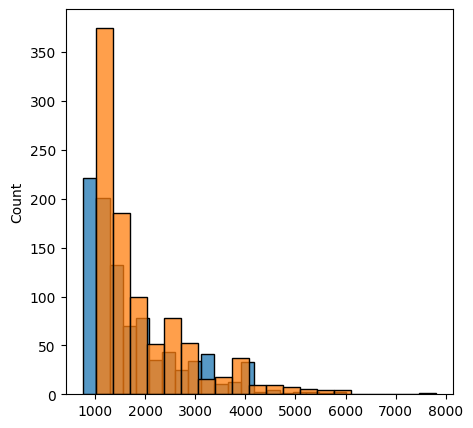

In [7]:
pixel_height, pixel_width = [], []
for c in os.listdir(dataset_root):
    for file in os.listdir(f"{dataset_root}/{c}"):
        img = cv2.imread(f"{dataset_root}/{c}/{file}")
        pixel_height += [img.shape[0]]
        pixel_width += [img.shape[1]]


sns.histplot(pixel_height, bins=20)
sns.histplot(pixel_width, bins=20)
plt.gcf().set_size_inches(5, 5)

In [8]:
max_size = 1000

for c in tqdm(os.listdir(dataset_root)):
    for file in os.listdir(f"{dataset_root}/{c}"):
        img = cv2.imread(f"{dataset_root}/{c}/{file}")
        if max(img.shape[:2]) > max_size:
            f = max_size / max(img.shape[:2])
            img = cv2.resize(img, dsize=None, fx=f, fy=f)
            cv2.imwrite(f"{dataset_root}/{c}/{file}", img)

100%|██████████| 5/5 [00:48<00:00,  9.70s/it]


# Датасет

In [4]:
test_size = 0.2

image_list = []
classes = sorted(os.listdir(dataset_root))

for c in classes:
    cls_img_list = list(os.listdir(f"{dataset_root}/{c}"))
    cls_img_list = [f"{c}/{i}" for i in cls_img_list]
    image_list += cls_img_list

train_img_list, test_img_list = train_test_split(
    image_list,
    test_size=test_size,
    random_state=42,
    shuffle=True
)

In [ ]:
### for consistency of random train/test splits with colab
import pickle

if colab:
    with open(f"{working_dir}/checkpoints/lists.pkl", 'wb') as f:
        pickle.dump((train_img_list, test_img_list), f)
else:
    with open(f"{working_dir}/checkpoints/lists.pkl", 'rb') as f:
        train_img_list, test_img_list = pickle.load(f)

In [6]:
train_dataset = CatDataset(dataset_root, train_img_list)
test_dataset = CatDataset(dataset_root, test_img_list)

d:\DEV\conda\envs\env3.10\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [7]:
classes_dict = {v: k for (k, v) in train_dataset.classes_dict.items()}

lbl_dict = {i:0 for i in range(5)}
for img_path in train_dataset.images:
    lbl = train_dataset.classes_dict[img_path.split("/")[0]]
    lbl_dict[lbl] += 1
classes_dict, lbl_dict


({0: 'bengal',
  1: 'domestic_shorthair',
  2: 'maine_coon',
  3: 'ragdoll',
  4: 'siamese'},
 {0: 146, 1: 134, 2: 150, 3: 170, 4: 160})

### Визуализация объектов каждого класса

In [12]:
idxs = []
for i in range(100):
    img, lbl = train_dataset[i]
    if np.argmax(lbl) == len(idxs):
        idxs += [i]
    if len(idxs) == 5: break

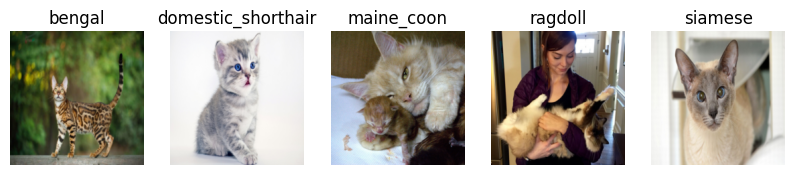

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i, idx in enumerate(idxs):
    img, lbl = train_dataset[idx]
    axes[i].imshow(img.permute((1, 2, 0)).numpy().clip(0, 1)[..., ::-1])
    axes[i].set_title(classes_dict[np.argmax(lbl.numpy())])
    axes[i].axis("off")

# Обучение моделей

In [22]:
loaders = getCatDatasetLoaders(train_dataset, test_dataset, batch_size=16)

### Простая свёртка

In [ ]:
model = build_simple_model()
model.eval()

img, lbl = train_dataset[0]
output = model(img[None, :, :])
output, lbl

(tensor([[0.2077, 0.1964, 0.2090, 0.2001, 0.1869]], grad_fn=<SoftmaxBackward0>),
 tensor([0., 0., 0., 1., 0.]))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

device = "cuda"

engine = Engine(
    model=model,
    device=device,
    logger_path=f"{working_dir}/checkpoints/simple/log.csv",
    checkpoint_path=f"{working_dir}/checkpoints/simple/",
    loss_func=nn.MSELoss(),
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    metric=AccuracyMetricFromProbs(n_classes=5)
)

In [ ]:
engine.run(loaders["train"], loaders["test"], epochs=15)

Epoch 0


Loss: 0.15122: 100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


TRAIN | Epoch 0: mean loss=0.159, acc=0.259, time: 903.298 ms


Loss: 0.15478: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]


VAL | Epoch 0: mean loss=0.157, acc=0.267, time: 880.628 ms
Epoch 1


Loss: 0.16405: 100%|██████████| 48/48 [00:18<00:00,  2.65it/s]


TRAIN | Epoch 1: mean loss=0.150, acc=0.357, time: 163.104 ms


Loss: 0.14466: 100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


VAL | Epoch 1: mean loss=0.151, acc=0.346, time: 866.832 ms
Epoch 2


Loss: 0.14752: 100%|██████████| 48/48 [00:18<00:00,  2.66it/s]


TRAIN | Epoch 2: mean loss=0.139, acc=0.455, time: 79.771 ms


Loss: 0.15566: 100%|██████████| 12/12 [00:04<00:00,  2.40it/s]


VAL | Epoch 2: mean loss=0.150, acc=0.330, time: 996.696 ms
Epoch 3


Loss: 0.09042: 100%|██████████| 48/48 [00:17<00:00,  2.71it/s]


TRAIN | Epoch 3: mean loss=0.128, acc=0.516, time: 728.889 ms


Loss: 0.14073: 100%|██████████| 12/12 [00:03<00:00,  3.09it/s]


VAL | Epoch 3: mean loss=0.145, acc=0.361, time: 890.032 ms
Epoch 4


Loss: 0.13537: 100%|██████████| 48/48 [00:18<00:00,  2.63it/s]


TRAIN | Epoch 4: mean loss=0.121, acc=0.549, time: 254.600 ms


Loss: 0.14696: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


VAL | Epoch 4: mean loss=0.149, acc=0.366, time: 475.696 ms
Epoch 5


Loss: 0.12690: 100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


TRAIN | Epoch 5: mean loss=0.114, acc=0.597, time: 903.511 ms


Loss: 0.14269: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s]


VAL | Epoch 5: mean loss=0.144, acc=0.372, time: 822.438 ms
Epoch 6


Loss: 0.08589: 100%|██████████| 48/48 [00:18<00:00,  2.54it/s]


TRAIN | Epoch 6: mean loss=0.108, acc=0.633, time: 887.273 ms


Loss: 0.14388: 100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


VAL | Epoch 6: mean loss=0.146, acc=0.351, time: 865.024 ms
Epoch 7


Loss: 0.13024: 100%|██████████| 48/48 [00:17<00:00,  2.68it/s]


TRAIN | Epoch 7: mean loss=0.103, acc=0.657, time: 920.482 ms


Loss: 0.14750: 100%|██████████| 12/12 [00:04<00:00,  2.57it/s]


VAL | Epoch 7: mean loss=0.146, acc=0.372, time: 676.894 ms
Epoch 8


Loss: 0.05985: 100%|██████████| 48/48 [00:18<00:00,  2.64it/s]


TRAIN | Epoch 8: mean loss=0.099, acc=0.661, time: 202.574 ms


Loss: 0.14076: 100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


VAL | Epoch 8: mean loss=0.146, acc=0.377, time: 973.583 ms
Epoch 9


Loss: 0.09499: 100%|██████████| 48/48 [00:17<00:00,  2.69it/s]


TRAIN | Epoch 9: mean loss=0.096, acc=0.683, time: 862.256 ms


Loss: 0.14467: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


VAL | Epoch 9: mean loss=0.145, acc=0.377, time: 155.239 ms
Epoch 10


Loss: 0.09202: 100%|██████████| 48/48 [00:18<00:00,  2.55it/s]


TRAIN | Epoch 10: mean loss=0.093, acc=0.709, time: 841.564 ms


Loss: 0.14809: 100%|██████████| 12/12 [00:03<00:00,  3.09it/s]


VAL | Epoch 10: mean loss=0.147, acc=0.361, time: 891.270 ms
Epoch 11


Loss: 0.04952: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


TRAIN | Epoch 11: mean loss=0.091, acc=0.716, time: 362.175 ms


Loss: 0.14883: 100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


VAL | Epoch 11: mean loss=0.146, acc=0.377, time: 978.989 ms
Epoch 12


Loss: 0.10964: 100%|██████████| 48/48 [00:20<00:00,  2.40it/s]


TRAIN | Epoch 12: mean loss=0.089, acc=0.712, time: 8.201 ms


Loss: 0.14490: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


VAL | Epoch 12: mean loss=0.146, acc=0.387, time: 131.768 ms
Epoch 13


Loss: 0.11232: 100%|██████████| 48/48 [00:18<00:00,  2.53it/s]


TRAIN | Epoch 13: mean loss=0.088, acc=0.724, time: 992.130 ms


Loss: 0.14658: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


VAL | Epoch 13: mean loss=0.146, acc=0.382, time: 559.780 ms
Epoch 14


Loss: 0.06718: 100%|██████████| 48/48 [00:20<00:00,  2.31it/s]


TRAIN | Epoch 14: mean loss=0.086, acc=0.718, time: 833.327 ms


Loss: 0.14933: 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]

VAL | Epoch 14: mean loss=0.146, acc=0.382, time: 922.910 ms


### EfficientNet-B0

In [ ]:
model = build_efficientnet_b0(n_classes=5)
model.eval()

(tensor([[0.2239, 0.1706, 0.2513, 0.1717, 0.1826]], grad_fn=<SoftmaxBackward0>),
 tensor([0., 0., 0., 1., 0.]))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

device = "cuda"

engine = Engine(
    model=model,
    device=device,
    logger_path=f"{working_dir}/checkpoints/efficientnet-b0/log.csv",
    checkpoint_path=f"{working_dir}/checkpoints/efficientnet-b0/",
    loss_func=nn.MSELoss(),
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    metric=AccuracyMetricFromProbs(n_classes=5)
)

In [ ]:
engine.run(loaders["train"], loaders["test"], epochs=10)

Epoch 0


Loss: 0.08093: 100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


TRAIN | Epoch 0: mean loss=0.087, acc=0.762, time: 75.768 ms


Loss: 0.10479: 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


VAL | Epoch 0: mean loss=0.071, acc=0.775, time: 978.395 ms
Epoch 1


Loss: 0.02387: 100%|██████████| 48/48 [00:20<00:00,  2.29it/s]


TRAIN | Epoch 1: mean loss=0.044, acc=0.879, time: 943.461 ms


Loss: 0.10540: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


VAL | Epoch 1: mean loss=0.061, acc=0.817, time: 406.834 ms
Epoch 2


Loss: 0.03536: 100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


TRAIN | Epoch 2: mean loss=0.029, acc=0.918, time: 554.481 ms


Loss: 0.10322: 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


VAL | Epoch 2: mean loss=0.057, acc=0.817, time: 768.617 ms
Epoch 3


Loss: 0.02835: 100%|██████████| 48/48 [00:21<00:00,  2.24it/s]


TRAIN | Epoch 3: mean loss=0.020, acc=0.953, time: 412.576 ms


Loss: 0.10130: 100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


VAL | Epoch 3: mean loss=0.055, acc=0.827, time: 279.985 ms
Epoch 4


Loss: 0.02938: 100%|██████████| 48/48 [00:21<00:00,  2.21it/s]


TRAIN | Epoch 4: mean loss=0.018, acc=0.953, time: 720.624 ms


Loss: 0.09950: 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


VAL | Epoch 4: mean loss=0.054, acc=0.817, time: 343.060 ms
Epoch 5


Loss: 0.01094: 100%|██████████| 48/48 [00:21<00:00,  2.22it/s]


TRAIN | Epoch 5: mean loss=0.011, acc=0.975, time: 682.065 ms


Loss: 0.10044: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


VAL | Epoch 5: mean loss=0.054, acc=0.812, time: 427.572 ms
Epoch 6


Loss: 0.01092: 100%|██████████| 48/48 [00:20<00:00,  2.30it/s]


TRAIN | Epoch 6: mean loss=0.008, acc=0.983, time: 853.332 ms


Loss: 0.10253: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


VAL | Epoch 6: mean loss=0.053, acc=0.827, time: 128.500 ms
Epoch 7


Loss: 0.03377: 100%|██████████| 48/48 [00:20<00:00,  2.30it/s]


TRAIN | Epoch 7: mean loss=0.010, acc=0.974, time: 912.275 ms


Loss: 0.10154: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


VAL | Epoch 7: mean loss=0.055, acc=0.817, time: 287.343 ms
Epoch 8


Loss: 0.03395: 100%|██████████| 48/48 [00:21<00:00,  2.28it/s]


TRAIN | Epoch 8: mean loss=0.008, acc=0.987, time: 23.665 ms


Loss: 0.10671: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


VAL | Epoch 8: mean loss=0.054, acc=0.822, time: 502.571 ms
Epoch 9


Loss: 0.01705: 100%|██████████| 48/48 [00:21<00:00,  2.23it/s]


TRAIN | Epoch 9: mean loss=0.006, acc=0.986, time: 531.265 ms


Loss: 0.09999: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


VAL | Epoch 9: mean loss=0.050, acc=0.843, time: 360.865 ms


### EfficientNet-B0 + augmentation

In [ ]:
train_dataset = CatDataset(dataset_root, train_img_list, augment=True)
test_dataset = CatDataset(dataset_root, test_img_list)

loaders = getCatDatasetLoaders(train_dataset, test_dataset, batch_size=16)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


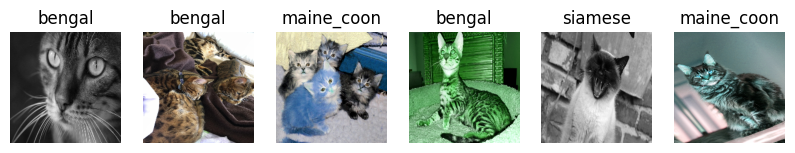

In [ ]:
N = 6
fig, axes = plt.subplots(1, N, figsize=(10, 5))
for idx in range(N):
    img, lbl = train_dataset[idx]
    axes[idx].imshow(img.permute((1, 2, 0)).numpy().clip(0, 1)[..., ::-1])
    axes[idx].set_title(classes_dict[np.argmax(lbl.numpy())])
    axes[idx].axis("off")

In [ ]:
model = build_efficientnet_b0(n_classes=5)
model.eval();

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

device = "cuda"

engine = Engine(
    model=model,
    device=device,
    logger_path=f"{working_dir}/checkpoints/efficientnet-b0-aug/log.csv",
    checkpoint_path=f"{working_dir}/checkpoints/efficientnet-b0-aug/",
    loss_func=nn.MSELoss(),
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    metric=AccuracyMetricFromProbs(n_classes=5)
)

In [ ]:
engine.run(loaders["train"], loaders["test"], epochs=10)

Epoch 0


Loss: 0.14560: 100%|██████████| 48/48 [00:18<00:00,  2.56it/s]


TRAIN | Epoch 0: mean loss=0.138, acc=0.493, time: 721.696 ms


Loss: 0.07791: 100%|██████████| 12/12 [00:03<00:00,  3.19it/s]


VAL | Epoch 0: mean loss=0.106, acc=0.675, time: 767.222 ms
Epoch 1


Loss: 0.10689: 100%|██████████| 48/48 [00:19<00:00,  2.40it/s]


TRAIN | Epoch 1: mean loss=0.084, acc=0.753, time: 975.386 ms


Loss: 0.04752: 100%|██████████| 12/12 [00:03<00:00,  3.22it/s]


VAL | Epoch 1: mean loss=0.067, acc=0.796, time: 738.247 ms
Epoch 2


Loss: 0.07030: 100%|██████████| 48/48 [00:18<00:00,  2.58it/s]


TRAIN | Epoch 2: mean loss=0.058, acc=0.826, time: 594.059 ms


Loss: 0.04598: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


VAL | Epoch 2: mean loss=0.065, acc=0.775, time: 319.034 ms
Epoch 3


Loss: 0.08047: 100%|██████████| 48/48 [00:18<00:00,  2.53it/s]


TRAIN | Epoch 3: mean loss=0.047, acc=0.855, time: 990.323 ms


Loss: 0.05004: 100%|██████████| 12/12 [00:03<00:00,  3.29it/s]


VAL | Epoch 3: mean loss=0.057, acc=0.780, time: 650.577 ms
Epoch 4


Loss: 0.04371: 100%|██████████| 48/48 [00:19<00:00,  2.50it/s]


TRAIN | Epoch 4: mean loss=0.041, acc=0.883, time: 231.831 ms


Loss: 0.04624: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


VAL | Epoch 4: mean loss=0.058, acc=0.791, time: 332.861 ms
Epoch 5


Loss: 0.08452: 100%|██████████| 48/48 [00:18<00:00,  2.59it/s]


TRAIN | Epoch 5: mean loss=0.032, acc=0.904, time: 539.405 ms


Loss: 0.03909: 100%|██████████| 12/12 [00:03<00:00,  3.09it/s]


VAL | Epoch 5: mean loss=0.058, acc=0.796, time: 887.904 ms
Epoch 6


Loss: 0.06048: 100%|██████████| 48/48 [00:20<00:00,  2.34it/s]


TRAIN | Epoch 6: mean loss=0.032, acc=0.907, time: 503.521 ms


Loss: 0.04083: 100%|██████████| 12/12 [00:03<00:00,  3.31it/s]


VAL | Epoch 6: mean loss=0.059, acc=0.791, time: 632.059 ms
Epoch 7


Loss: 0.00925: 100%|██████████| 48/48 [00:18<00:00,  2.53it/s]


TRAIN | Epoch 7: mean loss=0.027, acc=0.913, time: 979.395 ms


Loss: 0.03304: 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


VAL | Epoch 7: mean loss=0.057, acc=0.796, time: 792.012 ms
Epoch 8


Loss: 0.10774: 100%|██████████| 48/48 [00:18<00:00,  2.56it/s]


TRAIN | Epoch 8: mean loss=0.026, acc=0.926, time: 736.517 ms


Loss: 0.03765: 100%|██████████| 12/12 [00:03<00:00,  3.16it/s]


VAL | Epoch 8: mean loss=0.060, acc=0.759, time: 802.037 ms
Epoch 9


Loss: 0.02411: 100%|██████████| 48/48 [00:19<00:00,  2.41it/s]


TRAIN | Epoch 9: mean loss=0.023, acc=0.936, time: 902.781 ms


Loss: 0.03786: 100%|██████████| 12/12 [00:03<00:00,  3.23it/s]


VAL | Epoch 9: mean loss=0.059, acc=0.801, time: 729.517 ms


### EfficientNet-B4 + augmentation

In [17]:
train_dataset = CatDataset(dataset_root, train_img_list, augment=True)
test_dataset = CatDataset(dataset_root, test_img_list)

loaders = getCatDatasetLoaders(train_dataset, test_dataset, batch_size=16)

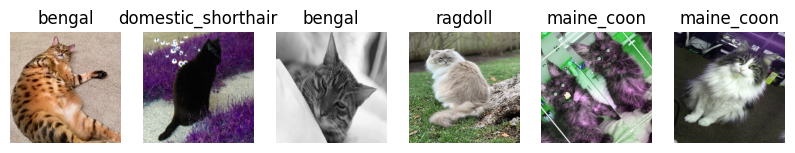

In [18]:
N = 6
fig, axes = plt.subplots(1, N, figsize=(10, 5))
for idx in range(N):
    img, lbl = train_dataset[idx]
    axes[idx].imshow(img.permute((1, 2, 0)).numpy().clip(0, 1)[..., ::-1])
    axes[idx].set_title(classes_dict[np.argmax(lbl.numpy())])
    axes[idx].axis("off")

In [19]:
model = build_efficientnet_b4(n_classes=5)
model.eval();

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 159MB/s]


In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

device = "cuda"

engine = Engine(
    model=model,
    device=device,
    logger_path=f"{working_dir}/checkpoints/efficientnet-b4-aug/log.csv",
    checkpoint_path=f"{working_dir}/checkpoints/efficientnet-b4-aug/",
    loss_func=nn.MSELoss(),
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    metric=AccuracyMetricFromProbs(n_classes=5)
)

In [21]:
engine.run(loaders["train"], loaders["test"], epochs=10)

Epoch 0


Loss: 0.13572: 100%|██████████| 48/48 [00:26<00:00,  1.79it/s]


TRAIN | Epoch 0: mean loss=0.154, acc=0.429, time: 776.340 ms


Loss: 0.14614: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


VAL | Epoch 0: mean loss=0.147, acc=0.618, time: 362.845 ms
Epoch 1


Loss: 0.11076: 100%|██████████| 48/48 [00:25<00:00,  1.91it/s]


TRAIN | Epoch 1: mean loss=0.132, acc=0.647, time: 130.168 ms


Loss: 0.10869: 100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


VAL | Epoch 1: mean loss=0.118, acc=0.675, time: 716.407 ms
Epoch 2


Loss: 0.06683: 100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


TRAIN | Epoch 2: mean loss=0.098, acc=0.713, time: 506.313 ms


Loss: 0.08815: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


VAL | Epoch 2: mean loss=0.085, acc=0.707, time: 164.048 ms
Epoch 3


Loss: 0.04836: 100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


TRAIN | Epoch 3: mean loss=0.072, acc=0.784, time: 836.566 ms


Loss: 0.08190: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


VAL | Epoch 3: mean loss=0.072, acc=0.738, time: 163.979 ms
Epoch 4


Loss: 0.04146: 100%|██████████| 48/48 [00:25<00:00,  1.88it/s]


TRAIN | Epoch 4: mean loss=0.061, acc=0.809, time: 605.620 ms


Loss: 0.08503: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


VAL | Epoch 4: mean loss=0.067, acc=0.754, time: 329.074 ms
Epoch 5


Loss: 0.02102: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s]


TRAIN | Epoch 5: mean loss=0.055, acc=0.828, time: 657.255 ms


Loss: 0.08235: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


VAL | Epoch 5: mean loss=0.064, acc=0.764, time: 355.358 ms
Epoch 6


Loss: 0.01636: 100%|██████████| 48/48 [00:25<00:00,  1.85it/s]


TRAIN | Epoch 6: mean loss=0.047, acc=0.854, time: 972.642 ms


Loss: 0.08156: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


VAL | Epoch 6: mean loss=0.063, acc=0.785, time: 322.585 ms
Epoch 7


Loss: 0.10303: 100%|██████████| 48/48 [00:26<00:00,  1.82it/s]


TRAIN | Epoch 7: mean loss=0.044, acc=0.863, time: 356.068 ms


Loss: 0.08964: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


VAL | Epoch 7: mean loss=0.060, acc=0.806, time: 391.902 ms
Epoch 8


Loss: 0.03490: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s]


TRAIN | Epoch 8: mean loss=0.043, acc=0.867, time: 734.545 ms


Loss: 0.08179: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


VAL | Epoch 8: mean loss=0.059, acc=0.812, time: 408.585 ms
Epoch 9


Loss: 0.05109: 100%|██████████| 48/48 [00:25<00:00,  1.92it/s]


TRAIN | Epoch 9: mean loss=0.039, acc=0.880, time: 42.871 ms


Loss: 0.08476: 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


VAL | Epoch 9: mean loss=0.058, acc=0.812, time: 978.004 ms


# Графики

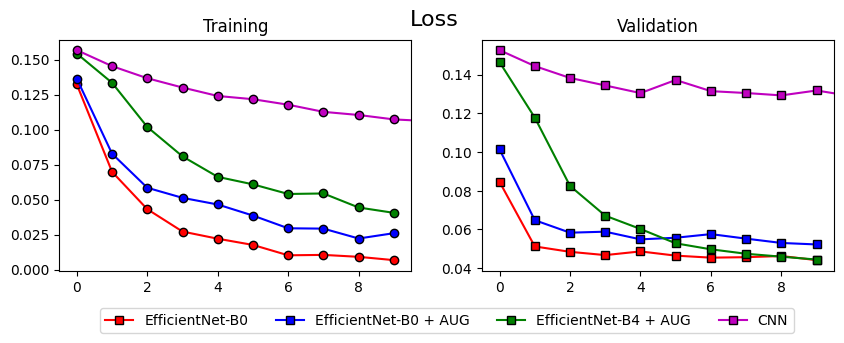

In [5]:
ckpt_path = Path(f"{working_dir}/checkpoints/")
labels = {
    "simple": "CNN",
    "efficientnet-b0": "EfficientNet-B0",
    "efficientnet-b0-aug": "EfficientNet-B0 + AUG",
    "efficientnet-b4-aug": "EfficientNet-B4 + AUG"
}

color_list = ['r', 'b', 'g', 'm']

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
i = 0
for folder in sorted(ckpt_path.iterdir()):
    if folder.is_file() or folder.name == ".ipynb_checkpoints" : continue
    data = pd.read_csv(f"{working_dir}/checkpoints/{folder.name}/log.csv")
    axes[0].plot(data['epoch'], data['train_loss'], f'{color_list[i]}-o', markeredgecolor='k', label=f'{labels[folder.name]}')
    axes[1].plot(data['epoch'], data['val_loss'], f'{color_list[i]}-s', markeredgecolor='k', label=f'{labels[folder.name]}')
    i += 1
    
axes[0].set_xlim(-0.5, 9.5)
axes[1].set_xlim(-0.5, 9.5)

axes[0].set_title("Training")
axes[1].set_title("Validation")

fig.suptitle("Loss", fontsize=16)
plt.legend(loc='lower center', ncols=4, bbox_to_anchor=(-0.1, -0.3))


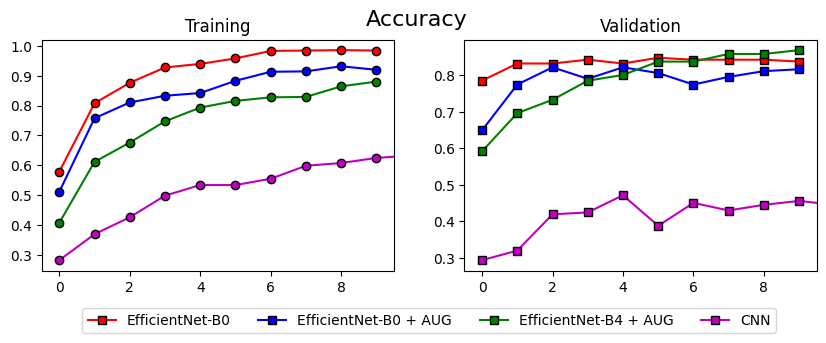

In [6]:
ckpt_path = Path(f"{working_dir}/checkpoints/")
labels = {
    "simple": "CNN",
    "efficientnet-b0": "EfficientNet-B0",
    "efficientnet-b0-aug": "EfficientNet-B0 + AUG",
    "efficientnet-b4-aug": "EfficientNet-B4 + AUG"
}

color_list = ['r', 'b', 'g', 'm']
i = 0
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for folder in sorted(ckpt_path.iterdir()):
    if folder.is_file() or folder.name == ".ipynb_checkpoints" : continue

    data = pd.read_csv(f"{working_dir}/checkpoints/{folder.name}/log.csv")
    axes[0].plot(data['epoch'], data['train_acc'], f'{color_list[i]}-o', markeredgecolor='k', label=f'{labels[folder.name]}')
    axes[1].plot(data['epoch'], data['val_acc'], f'{color_list[i]}-s', markeredgecolor='k', label=f'{labels[folder.name]}')
    i += 1
    
axes[0].set_xlim(-0.5, 9.5)
axes[1].set_xlim(-0.5, 9.5)

axes[0].set_title("Training")
axes[1].set_title("Validation")

fig.suptitle("Accuracy", fontsize=16)
plt.legend(loc='lower center', ncols=4, bbox_to_anchor=(-0.1, -0.3))


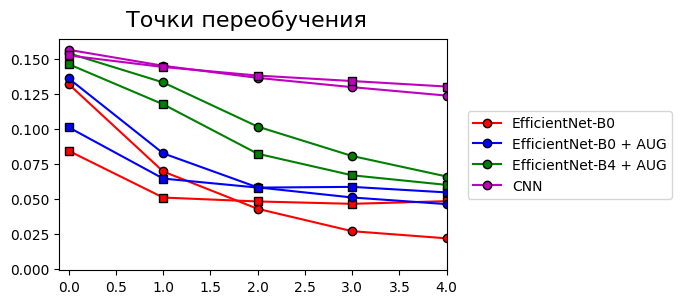

In [8]:
ckpt_path = Path(f"{working_dir}/checkpoints/")
labels = {
    "simple": "CNN",
    "efficientnet-b0": "EfficientNet-B0",
    "efficientnet-b0-aug": "EfficientNet-B0 + AUG",
    "efficientnet-b4-aug": "EfficientNet-B4 + AUG"
}

color_list = ['r', 'b', 'g', 'm']

fig, axes = plt.subplots(1, 1, figsize=(5, 3))
i = 0
for folder in sorted(ckpt_path.iterdir()):
    if folder.is_file() or folder.name == ".ipynb_checkpoints" : continue

    data = pd.read_csv(f"{working_dir}/checkpoints/{folder.name}/log.csv")
    axes.plot(data['epoch'], data['train_loss'], f'{color_list[i]}-o', markeredgecolor='k', label=f'{labels[folder.name]}')
    axes.plot(data['epoch'], data['val_loss'], f'{color_list[i]}-s', markeredgecolor='k', label='_')
    i += 1

axes.set_xlim(-0.1, 4)
fig.suptitle("Точки переобучения", fontsize=16)
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5))


# Сравнение работы моделей

In [11]:
ckpt_path = Path(f"{working_dir}/checkpoints/")
device = "cuda"

models = {
    'simple': build_simple_model(),
    'efficientnet-b0': build_efficientnet_b0(n_classes=5),
    'efficientnet-b0-aug': build_efficientnet_b0(n_classes=5),
    'efficientnet-b4-aug': build_efficientnet_b4(n_classes=5)
}

In [19]:
def get_result_arrays(model):
    ideal = []
    result = []

    for i, (xx, yy) in enumerate(loaders["test"]):
        with torch.no_grad():
            result_probs = model(xx.to(device)).cpu().numpy()
        result += [np.argmax(result_probs, axis=1)]
        ideal += [np.argmax(yy.cpu().numpy(), axis=1)]

    result = np.concatenate(result)
    ideal = np.concatenate(ideal)
    return result, ideal

In [20]:
max_idx = 10
idxs = np.random.choice(list(range(len(test_dataset))), max_idx)

def random_eval(model, model_name, idxs):
    fig, axes = plt.subplots(1, max_idx, figsize=(15, 5))
    for i, idx in enumerate(idxs):
        xx, yy = test_dataset[idx]
        with torch.no_grad():
            result_probs = model(xx.unsqueeze(0).to(device)).cpu().numpy()
        result = np.argmax(result_probs)

        axes[i].imshow(xx.permute((1, 2, 0)).numpy().clip(0, 1)[..., ::-1])
        axes[i].set_title(f"Pred: {result} GT:{np.argmax(yy.cpu().numpy())}")
        axes[i].axis("off")
    fig.suptitle(model_name.upper(), fontsize=16, y=0.7)
    plt.savefig(f"assets/{model_name}.png", bbox_inches="tight")

EFFICIENTNET-B0
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        31
           1       0.88      0.81      0.84        36
           2       0.90      0.95      0.93        39
           3       0.81      0.78      0.79        37
           4       0.81      0.79      0.80        48

    accuracy                           0.85       191
   macro avg       0.85      0.85      0.85       191
weighted avg       0.85      0.85      0.85       191

EFFICIENTNET-B0-AUG
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        31
           1       0.76      0.69      0.72        36
           2       0.85      1.00      0.92        39
           3       0.84      0.84      0.84        37
           4       0.85      0.73      0.79        48

    accuracy                           0.82       191
   macro avg       0.82      0.83      0.82       191
weighted avg       0.82      0.82      0.

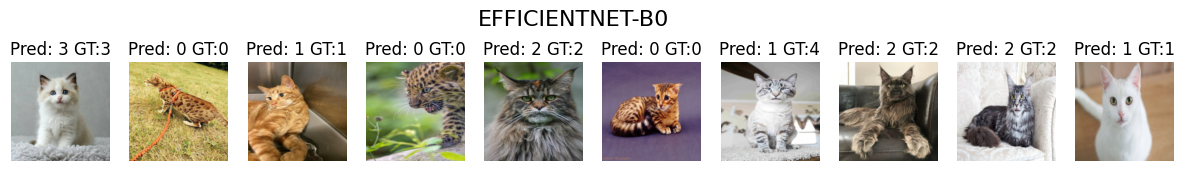

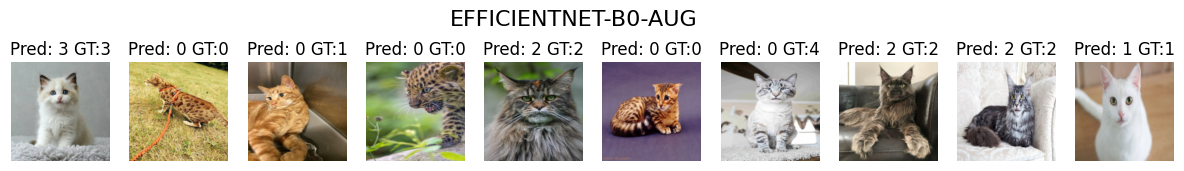

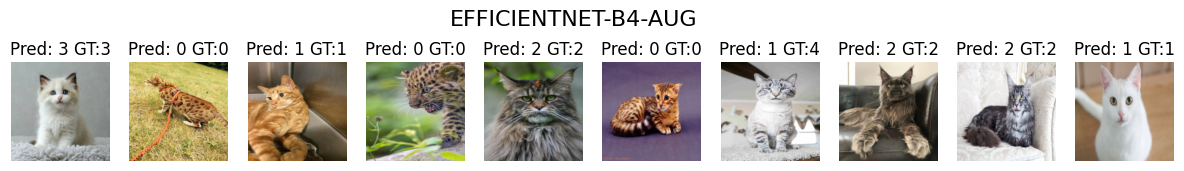

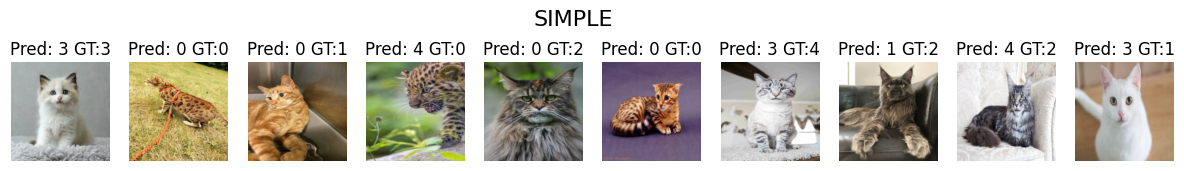

In [ ]:
for i, folder in enumerate(sorted(ckpt_path.iterdir())):
    if folder.name in [".ipynb_checkpoints", ".gitkeep", "lists.pkl"]: continue

    model = models[folder.name]
    model.load_state_dict(torch.load(folder / "best.pkl"))
    model = model.to(device)
    model.eval()
    print("=" * 50)
    print(folder.name.upper())

    y_pred, y_gt = get_result_arrays(model)
    print(classification_report(y_gt, y_pred))

    random_eval(model, folder.name, idxs)
    # break    


In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for i, folder in enumerate(sorted(ckpt_path.iterdir())):
    if folder.name in [".ipynb_checkpoints", ".gitkeep", "lists.pkl"]: continue

    model = models[folder.name]
    model.load_state_dict(torch.load(folder / "best.pkl"))
    model = model.to(device)
    model.eval()
    print(f"{folder.name.upper()}: {count_parameters(model)}")   

EFFICIENTNET-B0: 4013953
EFFICIENTNET-B0-AUG: 4013953
EFFICIENTNET-B4-AUG: 17557581
SIMPLE: 2603589
